<a href="https://colab.research.google.com/github/stochasticats/plantpathologyfgvc7-keras-deeplearning/blob/master/plantpathologyfgvc7_deeplearning_custommodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt

2.2.0-rc1


#Loading Data and Preprocessing.
Here we load the data and take a look at what we're dealing with.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -uq "/content/drive/My Drive/plant-pathology-2020-fgvc7.zip"

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

targets = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']]

In [5]:
print("Shape of train data: " + str(train_df.shape))
print("Shape of test data: " + str(test_df.shape))

Shape of train data: (1821, 5)
Shape of test data: (1821, 1)


In [6]:
train_len = train_df.shape[0]
test_len = test_df.shape[0]
print(train_len)
print(test_len) 

1821
1821


Let's see the distribution of images in terms of the targets/labels.

In [7]:
print(train_df.describe())
print(test_df.describe())

           healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000
         image_id
count        1821
unique       1821
top     Test_1211
freq            1


Ah, we see the multiple_diseases label has drastically less images than the rest of the labels. Once we load the images in raw data form, we'll use scikitlearn to randomly over sample so we can fix this class imbalance.

Now let's load the image data.

In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tqdm.notebook import tqdm

path = '/content/images/'
num_img = train_df.shape[0]
size = 224
train_images = np.ndarray(shape=(train_len, size, size, 3))
for i in tqdm(range(num_img)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  train_images[i] = np.float32(img_to_array(img))

test_images = np.ndarray(shape=(test_len, size, size, 3))
for i in tqdm(range(num_img)):
  img = load_img(path + f'Test_{i}.jpg', target_size=(size, size))
  test_images[i] = np.float32(img_to_array(img))

Using TensorFlow backend.


In [9]:
print(train_images.shape)
print(test_images.shape)

(1821, 224, 224, 3)
(1821, 224, 224, 3)


Here we see the images are in raw data form, with three matrices for RGB format. We'll rescale later on as well.

In [10]:
print(train_images[1])
print(train_images[1].shape)

[[[207. 219. 219.]
  [217. 228. 234.]
  [224. 234. 244.]
  ...
  [231. 255. 255.]
  [229. 255. 254.]
  [227. 250. 255.]]

 [[209. 221. 221.]
  [219. 230. 236.]
  [225. 235. 245.]
  ...
  [238. 255. 255.]
  [237. 255. 255.]
  [229. 253. 255.]]

 [[211. 223. 223.]
  [219. 230. 236.]
  [225. 235. 245.]
  ...
  [243. 255. 255.]
  [244. 255. 255.]
  [231. 255. 255.]]

 ...

 [[211. 211. 147.]
  [215. 216. 148.]
  [219. 217. 143.]
  ...
  [ 77. 113.  77.]
  [ 73. 110.  76.]
  [ 72. 109.  78.]]

 [[215. 212. 145.]
  [219. 216. 145.]
  [221. 219. 145.]
  ...
  [ 87. 123.  85.]
  [ 75. 116.  82.]
  [ 68. 109.  79.]]

 [[214. 214. 144.]
  [220. 216. 143.]
  [222. 219. 142.]
  ...
  [ 75. 114.  87.]
  [ 74. 111.  78.]
  [ 77. 115.  78.]]]
(224, 224, 3)


Let's take a look at what the images look like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


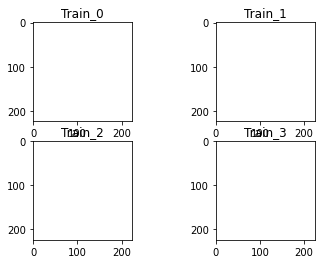

In [11]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(train_df['image_id'][i])
	plt.imshow(train_images[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


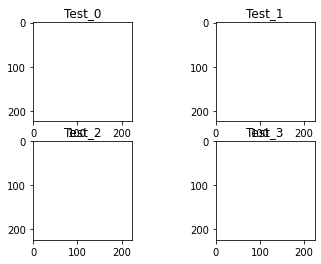

In [12]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(test_df['image_id'][i])
	plt.imshow(test_images[i])
plt.show()

Now let's fix the class imbalance with RandomOverSampler. This will add more images to the multiple_diseases class.

In [30]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(np.reshape(train_images, (-1, size * size * 3)), targets.to_numpy())
x_res = x_res.reshape((-1, size, size, 3))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [31]:
print(x_res.shape)
print(y_res.shape)

(2488, 224, 224, 3)
(2488, 4)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.1)

In [33]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2239, 224, 224, 3)
(249, 224, 224, 3)
(2239, 4)
(249, 4)


Now we prepare the data for going into a Keras deep learning model. Here I use the ImageDataGenerator to also give us more images by using the parameters to rotate, horizontally flip, and vertically flip. Also the image is rescaled by 1/255 to normalize the raw data so that the activation functions work properly.

In [0]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=40,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
    x = x_train, 
    y = y_train,
    batch_size = 32
    )

validation_generator = validation_datagen.flow(
    x = x_test,
    y = y_test,
    batch_size = 32
    )

Let's create the model. I use the Xception model (https://arxiv.org/abs/1610.02357) with an added dense layer with a softmax output of 4, since we are classifying into four classes. The Xception model is trained on a large image classification dataset comprising 350 million images and 17,000 classes!

In [52]:
def create_model():
  model = tf.keras.Sequential([
      # This is the first convolution
      tf.keras.layers.Conv2D(32, (3,3), input_shape=(size, size, 3), activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # The second convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Third conv layer
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Fourth conv layer
      #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      #tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Fifth conv layer
      #tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      #tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      # Flatten the results
      tf.keras.layers.Flatten(),
      #tf.keras.layers.Dropout(0.4),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(4, activation='softmax')
      ])
  
  model.compile(
        loss = 'categorical_crossentropy', 
        optimizer = 'adam', 
        metrics = ['accuracy'])
  return model

model = create_model()

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 51, 51, 128)       73856     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 80000)           

Learning rate per epoch:


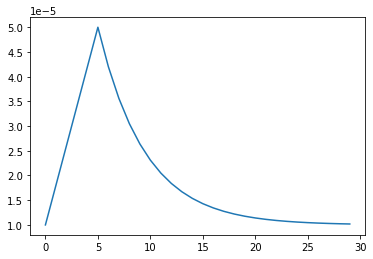

In [53]:
epochs = 30
batch_size = 32
steps_per_epoch = 100

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [54]:
history = model.fit(
    train_generator,  
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_steps = steps_per_epoch,
    verbose=1)

Epoch 1/30
100/100 [==============================] - 35s 348ms/step - loss: 1.4172 - accuracy: 0.3013 - val_loss: 1.4230 - val_accuracy: 0.3007
Epoch 2/30
100/100 [==============================] - 34s 343ms/step - loss: 1.2185 - accuracy: 0.4548 - val_loss: 1.3039 - val_accuracy: 0.3889
Epoch 3/30
100/100 [==============================] - 34s 343ms/step - loss: 1.0845 - accuracy: 0.5335 - val_loss: 0.9510 - val_accuracy: 0.5822
Epoch 4/30
100/100 [==============================] - 34s 341ms/step - loss: 0.9305 - accuracy: 0.6189 - val_loss: 0.9500 - val_accuracy: 0.6056
Epoch 5/30
100/100 [==============================] - 34s 339ms/step - loss: 0.8452 - accuracy: 0.6460 - val_loss: 0.7980 - val_accuracy: 0.6639
Epoch 6/30
100/100 [==============================] - 34s 340ms/step - loss: 0.7176 - accuracy: 0.7099 - val_loss: 0.7557 - val_accuracy: 0.6999
Epoch 7/30
100/100 [==============================] - 34s 341ms/step - loss: 0.6740 - accuracy: 0.7261 - val_loss: 0.7568 - val_ac

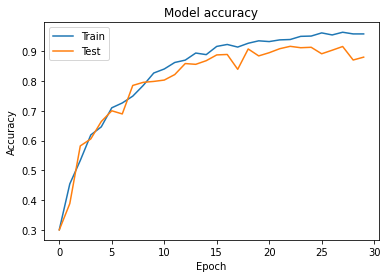

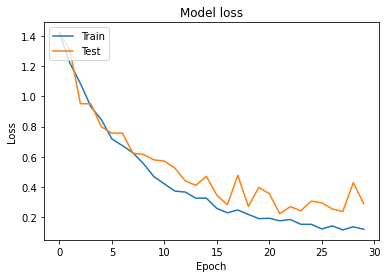

In [56]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [57]:
probabilities = model.predict(test_images)
print(probabilities)
print(probabilities[:,0].mean())
print(probabilities[:,1].mean())
print(probabilities[:,2].mean())
print(probabilities[:,3].mean())

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
0.43029028
0.0137288235
0.47884938
0.0771315


In [0]:
test = pd.read_csv('test.csv')
res = pd.DataFrame()
res['image_id'] = test['image_id']
res['healthy'] = probabilities[:, 0]
res['multiple_diseases'] = probabilities[:, 1]
res['rust'] = probabilities[:, 2]
res['scab'] = probabilities[:, 3]

In [0]:
res.to_csv('submission.csv', index=False)